# Classically controlled gates



In this notebook, you will learn how to ...
* ... to use mid-circuit measurements and apply classically controlled gates based on these measurements.


### Installing the necessary packages
In order to get started, make sure you have the appropriate packages installed:

In [5]:
%%capture
!pip install -U "iqm-client[qiskit]"

In order to access IQM Garnet through IQM Resonance, you will need to create an API Token. Copy the token, execute the cell, and paste the token to store it as an environment variable (or follow the guidelines for your system to create an environment variable).

In [1]:
import os
os.environ["IQM_TOKEN"] = input()

# Or load Resonance token from .env file
#from dotenv import load_dotenv
#load_dotenv()
#token = os.getenv("TOKEN")
#os.environ["IQM_TOKEN"] = token

## Connecting to an IQM Quantum Computer

Let's first check that our connection is working.

We do this by authenticating ourselves to IQM Resonance and select a device. We have chosen Sirius here.

In [4]:
from iqm.qiskit_iqm import IQMProvider

server_url = 'https://cocos.resonance.meetiqm.com/garnet'

print(f"Create CoCoS backend: {server_url}")
provider = IQMProvider(server_url)
backend = provider.get_backend()

Create CoCoS backend: https://cocos.resonance.meetiqm.com/garnet


## General information

Global feedback is enabled in groups. For IQM Garnet, the qubits are divided into 2 groups. Each group has a different color in the figure below.
It is not yet possible to apply feedback between qubit groups. Only qubits within the same color group can be used for classically-conditioned gates. 

**Please make sure that your circuit obeys this rule manually. The transpiler will not consider this constraint!**

![/notebooks/iqm/general/prx-feedback-groups-garnet.jpg](/notebooks/iqm/general/prx-feedback-groups-garnet.jpg)

## Example circuit

Let's prepare a simple circuit using qiskit to see how to use mid-circuit measurements and apply gates based on these measurements.

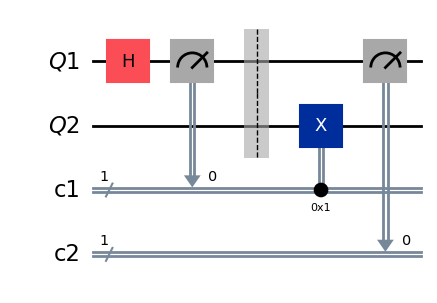

In [5]:
from qiskit import visualization, QuantumCircuit, ClassicalRegister, QuantumRegister, transpile
from qiskit.visualization import plot_histogram


qubit_c = QuantumRegister(1, "Q1")
qubit_t = QuantumRegister(1, "Q2")
c1 = ClassicalRegister(1, "c1")
c2 = ClassicalRegister(1, "c2")

protocol = QuantumCircuit(qubit_c, qubit_t, c1, c2)

# Prepare control qubit and measure
protocol.h(qubit_c)
protocol.measure(qubit_c, c1)
protocol.barrier()

# Performed conditional x-gate on target qubit
protocol.x(qubit_t).c_if(c1 ,1)
protocol.measure(qubit_c, c2)

display(protocol.draw('mpl'))

As a next step, we take this circuit and transpile it to IQM Garnet.

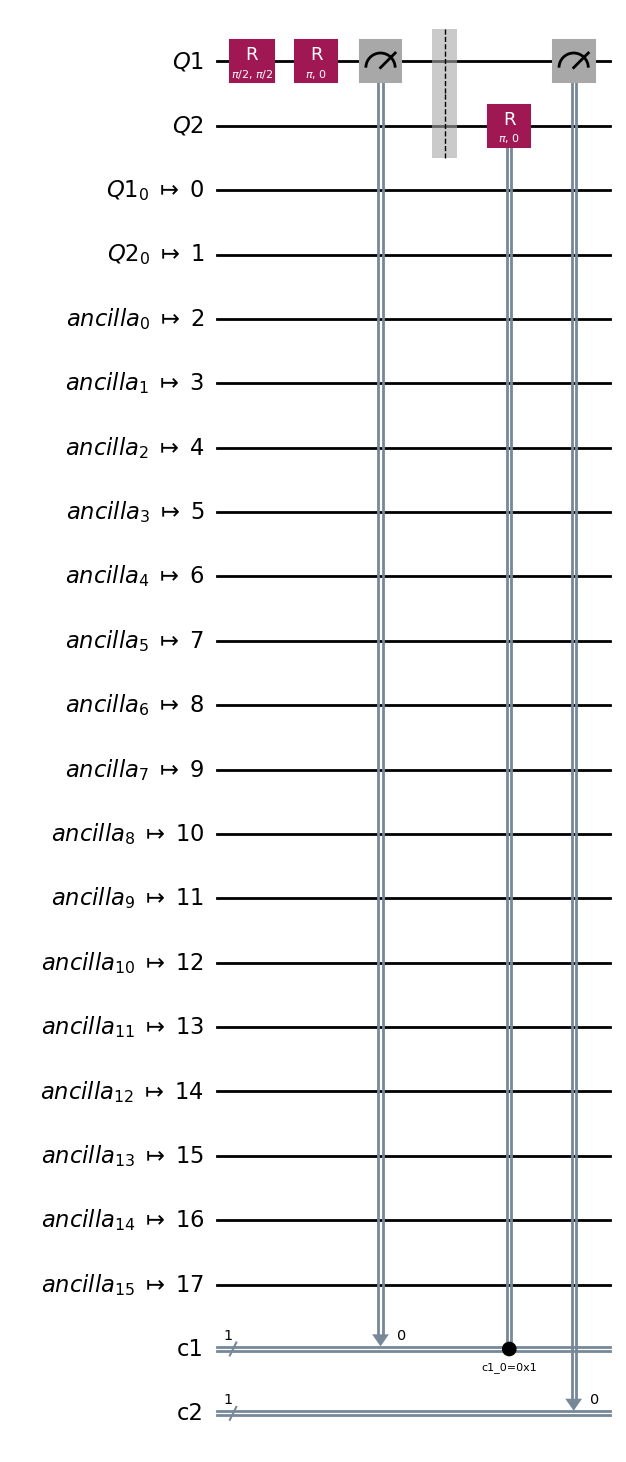

In [6]:
transpiled_qc = transpile(protocol, backend=backend, optimization_level=0)

transpiled_qc.draw('mpl')

Now that we have a circuit, we can measure and plot the results. The above circuit will perform an X-gate on Q2 if qubit Q1 is in state 1. As Q1 is initially prepared in a superposition state, the expected result is either 00 or 11 with 50% each.

{'1 1': 2407, '0 0': 2404, '0 1': 155, '1 0': 34}


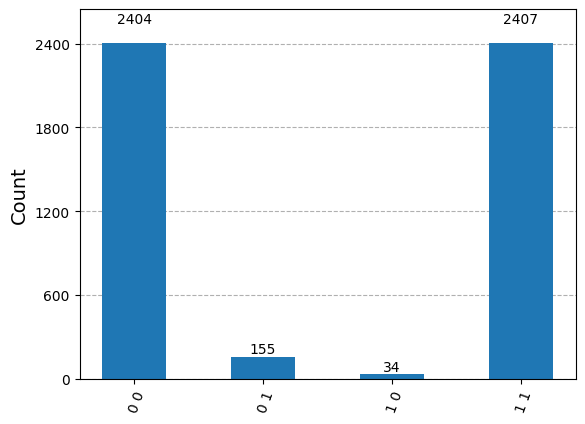

In [7]:
shots = 5000

job = backend.run(transpiled_qc, shots=shots)

print(job.result().get_counts())

# Plot result
result_dict = job.result().get_counts()
visualization.plot_histogram(result_dict)

# Limitations

**1. Each channel can listen to just one source (qubit) in a single circuit**

Each channel can listen to just one source (qubit) in a single circuit, so you cannot apply two sources to the same qubit (in the example below `qb2`)

Trying to submit such circuit will lead to an error message similar to this:
`CircuitExecutionError: Error while retrieving sweep <sweep_id> from station-control`

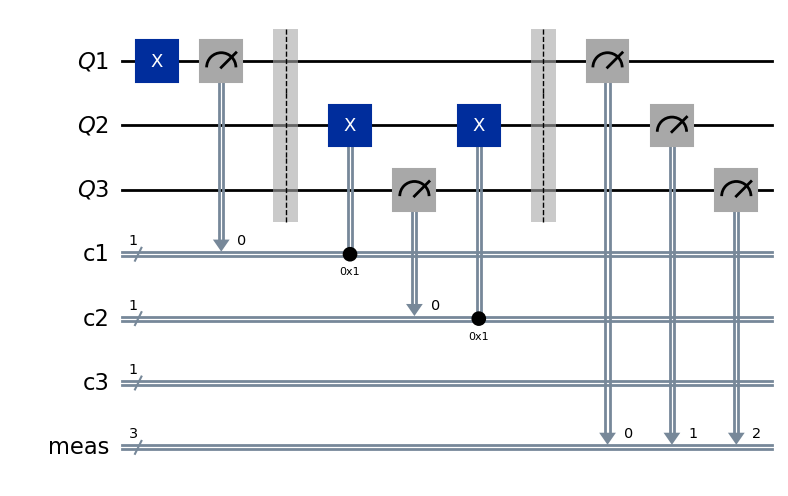

CircuitExecutionError: iqm.station_control.engine.controllers.programmable_controller.CompilationError: Playlist segment 0 can't be handled by the instruments and can't be broken to smaller parts. Violated limits:
- QB2__drive.awg unique feedback signal labels: 2/1


In [ ]:
qb1 = QuantumRegister(1, "Q1")
qb2 = QuantumRegister(1, "Q2")
qb3 = QuantumRegister(1, "Q3")
c1 = ClassicalRegister(1, "c1")
c2 = ClassicalRegister(1, "c2")
c3 = ClassicalRegister(1, "c3")

protocol = QuantumCircuit(qb1, qb2, qb3, c1, c2, c3)

# Prepare control qubit and measure
protocol.x(qb1)
protocol.measure(qb1, c1)
protocol.barrier()

# Performed conditional x-gate on other qubits
protocol.x(qb2).c_if(c1 ,1)
protocol.measure(qb3, c2)
protocol.x(qb2).c_if(c2 ,1)


protocol.measure_all()
display(protocol.draw('mpl'))

# Transpile
transpiled_qc = transpile(protocol, backend=backend, optimization_level=0)

# Measure and plot
shots = 1000

job = backend.run(transpiled_qc, shots=shots)

print(job.result().get_counts())

# Plot result
result_dict = job.result().get_counts()
visualization.plot_histogram(result_dict)

**#2 Only certain qubit conbinations can be used for classically controlled PRX gates**

Here, we intentionally transpile to two qubits between which a classically controlled gate is not allowed. Consequently, the execution will fail. This will be changed with future system updates. For now, please refer to the figure at the top of this notebook (or the quantum computer details page in Resonance) for information about feedback sub groups.

Trying to submit such circuit will lead to an error message similar to this:
`RuntimeError: Error in stage "circuit_resolution" pass "resolve_circuits": AWG node QB20__drive.awg does not support fast feedback from PL-3`

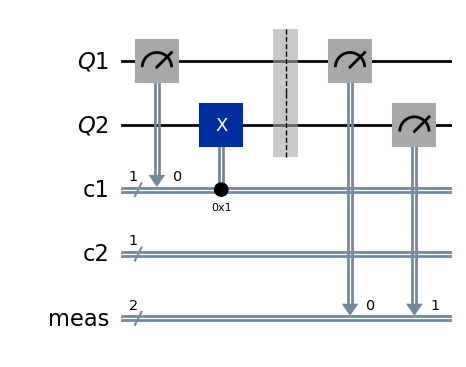

RuntimeError: dummy


In [ ]:
qb1 = QuantumRegister(1, "Q1")
qb2 = QuantumRegister(1, "Q2")
c1 = ClassicalRegister(1, "c1")
c2 = ClassicalRegister(1, "c2")

protocol = QuantumCircuit(qb1, qb2, c1, c2)

protocol.measure(qb1, c1)
protocol.x(qb2).c_if(c1 ,1)

protocol.measure_all()
display(protocol.draw('mpl'))

# Transpile
qubit_names = ["QB19", "QB20"]
qubit_indices = [backend.qubit_name_to_index(name) for name in qubit_names]

transpiled_qc = transpile(protocol, backend=backend, optimization_level=0, initial_layout=qubit_indices)

transpiled_qc.draw('mpl')

# Measure and plot
shots = 1000

job = backend.run(transpiled_qc, shots=shots)

print(job.result().get_counts())

# Plot result
result_dict = job.result().get_counts()
visualization.plot_histogram(result_dict)

In [ ]:

# Copyright 2025 IQM Quantum Computers (Stefan Pogorzalek, Stefan Seegerer)
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.